# fastMRI Super Res

Idea - progressive resizing -> progressive lower-resolution, train with 16x accel, 8x accel, then 4x accel

## Setup

In [1]:
# Settings
PROJ = "fastmri"

DO_GDRIVE_SETUP = True
DO_GITHUB_SETUP = False

def run_setup_helpers(path):
  %run "$path/common_constants_env.ipynb" # pip install fastai, fastmri, etc
  %run "$path/04_kspace_tfms.ipynb"       # get the kspace tfms
  %run "$path/Crappify_Sandwich_Tfms.ipynb"        # get P & Sandw tfms

from google.colab import drive
from pathlib      import Path 

if DO_GDRIVE_SETUP:
  ROOT = "/content/drive"     # default location for the drive
  drive.mount(ROOT)           # mount google drive at /content/drive
  
  G_PATH = Path(ROOT)/"My Drive/fastai_proj/"/PROJ  # GDRIVE path
  G_PATH.mkdir(parents=True, exist_ok=True)
  run_setup_helpers(G_PATH)

if DO_GITHUB_SETUP:
  !git clone https://github.com/RGologorsky/fastmri.git
  run_setup_helpers(PROJ)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
pip install runstats
sys append /content/fastMRI - for transforms T, evaluation metrics E
imports


## Super resolution data

In [2]:
import json
import pickle

# choose dataset
ds_name = "knee_singlecoil_val"
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

ds_path = G_PATH/"data"/DS2DIR[ds_name]

# load json
with open(ds_path/"fn2attr.json", "r") as f:
  fn2attr = json.load(f)
  fn2attr_items = L(i for i in fn2attr.items())

hr_ims, lr_ims = open_pickle("imspaces.p", "masked_imspaces_001.p")
 
print(f"DS: {ds_name}, no. vols: {len(fn2attr_items)}")

DS: knee_singlecoil_val, no. vols: 40


In [3]:
# for scaling
with open(ds_path/"uni_bins_40.npy", 'rb') as f:
  bins_np = np.load(f)

In [4]:
# indexes into array of kspace slices
class HrLrSandw(Transform):

  def __init__(self, fn2attr_items, hr_objs, lr_objs, n_seq = 5):
    self.n_seq = n_seq
    self.fn2attr_items = fn2attr_items

    # set objs (either those given as input or load into RAM h5 files)
    self.hr_objs = hr_objs
    self.lr_objs = lr_objs

    # how many slices/sandwiches per file
    self.n_slices = [attr["n_slices"] for (_, attr) in self.fn2attr_items]
    self.n_sandws = [n-(self.n_seq-1) for n in self.n_slices]

    # given dataset index, cumsum is used to index into appropriate file
    self.cumsum_n_slices = np.cumsum(self.n_slices)
    self.cumsum_n_sandws = np.cumsum(self.n_sandws)

    # total number of slices/sandwiches in dataset (for reference)
    self.total_n_slices   = self.cumsum_n_slices[-1]
    self.total_n_sandws   = self.cumsum_n_sandws[-1]

  # returns index in fn2attr corresponding to given sandwich
  def sandw2fn_idx(self, i): return np.searchsorted(self.cumsum_n_sandws, i)
  
  def encodes(self, sandw_idx):
    # get file index from sandw number (idx 0 = first sandwich = sandwich #1)
    fn_idx  = self.sandw2fn_idx(sandw_idx + 1)

    # sandwich index within file
    n_sandw_prior_vol = 0 if fn_idx == 0 else self.cumsum_n_sandws[fn_idx - 1]
    sw_idx  = sandw_idx - n_sandw_prior_vol # 15sandw in file = 14th index
    
    # get imspace sandwich, target slice + neighbor slices on either side
    hr_imsandw  = self.hr_objs[fn_idx][sw_idx:sw_idx+self.n_seq]
    lr_imsandw  = self.lr_objs[fn_idx][sw_idx:sw_idx+self.n_seq]     

    return lr_imsandw, hr_imsandw

### Dataset

In [5]:
# shapes of im volumes
im_shapes = [im.shape[-2:] for im in hr_ims]
get_shapes_info(im_shapes);

# resize all images to same size. Either CROP to MIN DIM or PAD to MAX DIM.
crop_shape = get_common_shape(im_shapes, do_print=True)

hr_ims_cropped = [T.center_crop(im, crop_shape) for im in hr_ims]
lr_ims_cropped = [T.center_crop(im, crop_shape) for im in lr_ims]

hr_crop_info = get_shapes_info([im.shape[-2:] for im in hr_ims_cropped])
lr_crop_info = get_shapes_info([im.shape[-2:] for im in lr_ims_cropped])

Unique Sizes & Counts: 
(array([640, 372]), 37, 0)
(array([640, 400]), 1, 29)
(array([640, 454]), 1, 35)
(array([640, 644]), 1, 6)
Common shape: (640, 372)
Unique Sizes & Counts: 
(array([640, 372]), 40, 0)
Unique Sizes & Counts: 
(array([640, 372]), 40, 0)


In [6]:
# dataset = indices, sandw_tfm converts index to sandwich
sandw_tfm = HrLrSandw(fn2attr_items, hr_ims_cropped, lr_ims_cropped, n_seq=5) 
raw_items = range(sandw_tfm.total_n_sandws)

# split between training/valid
splitter = RandomSplitter(valid_pct=0.2, seed=42)
splits   = splitter(raw_items)
print(f"#train/#valid = {len(splits[0]), len(splits[1])}")

ds        = TfmdLists(raw_items, tfms=[sandw_tfm], splits=splits)

#train/#valid = (957, 239)


#### Padding

Optional

In [7]:
# Experiment -- padding deep dive

# remove zero padding in image. No useful info: http://mri-q.com/zip.html
def im_nopad(im, pad_left, pad_right): return im[:, :, pad_left:pad_right]

# remove zero padding common to all images.
pad_shapes = [(o[1]["padding_left"], o[1]["padding_right"]) for o in fn2attr_items]
pad_info   = get_shapes_info(pad_shapes)
pad_shape  = get_common_shape(pad_shapes, f0 = np.min, f1 = np.max, do_print = True)

hr_ims_nopad = [im_nopad(im, *pad_shape) for im in hr_ims]
lr_ims_nopad = [im_nopad(im, *pad_shape) for im in lr_ims]

Unique Sizes & Counts: 
(array([ 19, 354]), 37, 0)
(array([ 32, 612]), 1, 6)
(array([ 40, 360]), 1, 29)
(array([ 57, 397]), 1, 35)
Common shape: (19, 612)


In [8]:
hr_ims_nopad_i = [im_nopad(im, *pad_shape) for im, pad_shape in zip(hr_ims, pad_shapes)]
get_shapes_info([im.shape[-2:] for im in hr_ims_nopad]);
get_shapes_info([im.shape[-2:] for im in hr_ims_nopad_i]);

Unique Sizes & Counts: 
(array([640, 353]), 37, 0)
(array([640, 381]), 1, 29)
(array([640, 435]), 1, 35)
(array([640, 593]), 1, 6)
Unique Sizes & Counts: 
(array([640, 320]), 1, 29)
(array([640, 335]), 37, 0)
(array([640, 340]), 1, 35)
(array([640, 580]), 1, 6)


Summary

| count | index | px height | px width | pad_left | pad_right | Total width |
|-------|-------|-----------|----------|----------|-----------|-------------|
| 37    | 0     | 640       | 372      | 19       | 354       | 335         |
| 1     | 29    | 640       | 400      | 40       | 360       | 320         |
| 1     | 35    | 640       | 454      | 57       | 397       | 340         |
| 1     | 6     | 640       | 644      | 32       | 612       | 580         |

In [9]:
# plot the vols of shape 640 vs 372 (the majority)
reg_ims, reg_nopad_ims = zip(*[(im,im_nopad) for im, im_nopad in zip(hr_ims, hr_ims_nopad_i) 
                              if np.array_equal(im.shape[-2:], [640, 372])])

print(len(reg_ims), len(reg_nopad_ims))

# plot a slice in each vol of shape 640 vs 372
slice_idx = 20
reg_slices   = [im[slice_idx] for im in reg_ims]
nopad_slices = [im[slice_idx] for im in reg_nopad_ims]
ims = [s[i] for i in range(len(reg_slices)) for s in [reg_slices, nopad_slices]]

# plot(ims, cmaps=cmap_options[1], nrows=len(reg_ims), ncols=2, figsize=(10,80))

37 37


In [10]:
# plot the vols with unique shape. Idx 6 
vol_idx = 6
vol, nopad_vol = hr_ims[vol_idx], hr_ims_nopad_i[vol_idx]

nopad_vol = T.center_crop(vol, shape=(640,372)) #im_nopad(vol, 32, 500)

print(vol.shape, nopad_vol.shape)

reg_slices   = toL(vol)
nopad_slices = toL(nopad_vol)
ims = [s[i] for i in range(len(reg_slices)) for s in [reg_slices, nopad_slices]]

# plot(ims, cmaps=cmap_options[1], nrows=len(reg_slices), ncols=2, figsize=(10,80))

torch.Size([33, 640, 644]) torch.Size([33, 640, 372])


In [11]:
vol_idx = 35
vol, nopad_vol = hr_ims[vol_idx], hr_ims_nopad_i[vol_idx]

print(vol.shape, nopad_vol.shape)

reg_slices   = toL(vol)
nopad_slices = toL(nopad_vol)
ims = [s[i] for i in range(len(reg_slices)) for s in [reg_slices, nopad_slices]]

# plot(ims, cmaps=cmap_options[1], nrows=len(reg_slices), ncols=2, figsize=(10,80))

torch.Size([35, 640, 454]) torch.Size([35, 640, 340])


### Dataloaders

In [12]:
# parameters
orig_bs     = 4
num_workers = 1

In [13]:
aug_tfms   = [] #[RandomDihedral(tfm_y=TfmType.PIXEL)]
item_tfms  = []
batch_tfms = [] # No normalization 

dls = ds.dataloaders(
          after_item  = item_tfms, 
          after_batch = batch_tfms, 
          bs=orig_bs, 
          num_workers = num_workers).cuda()

#### Viz DL batch

In [14]:
xb,yb = next(iter(dls.train_ds))
print("X batch: ", xb.size(), "Y batch: ", yb.size())

# Viz one slice in batch
slice_idx = 1
n_seq = sandw_tfm.n_seq

ims    = L([xb[slice_idx], yb[slice_idx]]) * 2
titles = L(["LR", "HR"]) * 2

cmap_options = ["gray", plt.cm.gist_ncar]
cmaps = L(cmap_options[0]) * 2 + L(cmap_options[1]) * 2

plot(ims, titles, cmaps, nrows=1, ncols=4, figsize=(12,6))

# Viz all slices in batch
ims = toL(xb) + toL(yb)
titles = [f"{res} {i}" for res in ("HR", "LR") for i in range(n_seq)]
cmaps = ["gray", plt.cm.gist_ncar]

plot(ims, titles, nrows=2, ncols=n_seq, figsize=(20,15), cmaps=cmaps[1])
plt.subplots_adjust(wspace=0, hspace=0)

Output hidden; open in https://colab.research.google.com to view.

# Loss fn / Metrics

Components of loss function/metrics.

- L1 loss to compare pixel values
- L1 loss to compare feature activations ("perceptual" loss)
- PSNR, SSIM?
- MSE, NMSE?

Source: 
- fastAI metrics: https://docs.fast.ai/metrics.html#mean_squared_error
- fastMRI metrics: https://github.com/facebookresearch/fastMRI/blob/master/common/evaluate.py

In [14]:
from skimage.metrics import structural_similarity, peak_signal_noise_ratio

# Batch-level
def mse(pred:Tensor, targ:Tensor):
  "Mean squared error between `pred` and `targ`."
  pred,targ = flatten_check(pred,targ)
  return F.mse_loss(pred, targ)

def psnr(input:Tensor, targs:Tensor):
  return 10 * (targs.max() ** 2 / mean_squared_error(input, targs)).log10()

def nmse(pred, targ):
    """ Compute Normalized Mean Squared Error (NMSE) """
    return np.linalg.norm(targ - pred) ** 2 / np.linalg.norm(targ) ** 2


def ssim(targ, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """

    # multichannel: treat last dimension of arr as channel
    # data range: dist between min/max values in image
    return structural_similarity(
        targ.transpose(1, 2, 0), 
        pred.transpose(1, 2, 0), 
        multichannel=True, 
        data_range=targ.max()
    )

# class SSIM_Vol(RegMetrics):
#     "Computes the root mean squared error."
#     def on_epoch_end(self, last_metrics, **kwargs):
#         return add_metrics(last_metrics, root_mean_squared_error(self.preds, self.targs))

## Feature Loss Model

Source: adapted from https://github.com/fastai/fastai2/blob/master/nbs/course/lesson7-superres.ipynb

In [17]:
# import fastai
# from fastai.vision import *
# from fastai.callbacks import *
# from fastai.utils.mem import *

In [15]:
class BasicFeatureLoss(Module):
    def __init__(self, m_feat, layer_idxs, layer_wgts, base_loss = F.l1_loss):
        self.m_feat   = m_feat     # m_feat is the model we run to get features
        self.wgts     = layer_wgts # how much to weight each layer's feature activations
        self.base_loss = base_loss # loss between m_feat's input/target activations
        
        # calculate loss during forward pass 
        self.loss_features = [self.m_feat[i] for i in layer_idxs]
        self.hooks = hook_outputs(self.loss_features, detach=False)

        # metrics/components of loss fn (pixel loss,feature loss,gram loss,etc)
        self.metric_names = ['pixel'] + \
                            [f'feat_{i}' for i in range(len(layer_idxs))]

    # fwd pass in feature model (get & store feature activations)
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target, reduction='mean'):
        # compare input & target feature activitations
        out_feat = self.make_features(target, clone=True)
        in_feat  = self.make_features(input)

        # L1 loss between input/output pixels
        self.feat_losses = [self.base_loss(input,target,reduction=reduction)]
        
        # L1 loss between input/output feature activations
        self.feat_losses += [self.base_loss(f_in, f_out,reduction=reduction)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]


        # store metrics
        for n,l in zip(self.metric_names, self.feat_losses): setattr(self, n, l)
        
        # return total loss
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()


# Load feature model

In [18]:
# m_feat
c_in  = sandw_tfm.n_seq
n_out = c_in * (c_in - 1)//2
m_feat = xresnet34(c_in=c_in, n_out=n_out)

# load pre-trained weights
MODEL_DIR     = G_PATH/"models"
m_feat_FN    = "SandwClassifierRAM-epoch15-norm-no-presize.pth"

enc_state_dict = torch.load(MODEL_DIR/m_feat_FN)
m_feat.load_state_dict(enc_state_dict['model'])

#m_feat =  nn.Sequential(*list(m_feat.children())[:cut])
# find cut point
# cut = model_meta[xresnet34]["cut"]
# print("Cut point ", cut)

# Alternative way to find cut point:
# ll = list(enumerate(m_feat.children()))
# cut = next(i for i,o in reversed(ll) if has_pool_type(o)) 

# m_feat =  nn.Sequential(*list(m_feat.children())[:cut])

# maske sure body on cuda
#m_feat_body.train();
# m_feat_body.summary()
#m_feat_body = m_feat_body.to(torch.device("cuda"))

<All keys matched successfully>

In [19]:
m_feat.features

ModuleAttributeError: ignored

In [21]:
# Set feature loss model -- VGG issue w/ diff number input channels
m_feat_cuda = m_feat.cuda().eval()
m_feat_cuda = m_feat_cuda.requires_grad_(False)

blocks = [i-1 for i,o in enumerate(m_feat_cuda.children()) if isinstance(o,nn.MaxPool2d)]
print("Before Maxpool (ie ReLU). Layers idxs: ", blocks, "\n", "Layer Name: ", [m_feat_cuda[i] for i in blocks])

feat_loss = BasicFeatureLoss(m_feat_cuda, blocks, [5])

Before Maxpool (ie ReLU). Layers idxs:  [2] 
 Layer Name:  [ConvLayer(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
)]


In [22]:
# from torchvision.models import vgg16_bn

# # Set feature loss model == VGG for now, pretrained unet down path later??
# vgg_m = vgg16_bn(True).features.cuda().eval()
# vgg_m = vgg_m.requires_grad_(False)

# blocks = [i-1 for i,o in enumerate(vgg_m.children()) if isinstance(o,nn.MaxPool2d)]
# print("Before Maxpool (ie ReLU). Layers idxs: ", blocks, "\n", "Layer Name: ", [vgg_m[i] for i in blocks])

# feat_loss = BasicFeatureLoss(vgg_m, blocks[2:5], [5,15,2])

# Train

In [20]:
from fastai2.vision.models import resnet34
m = resnet34(pretrained=False)
m = nn.Sequential(*list(m.children())[:-2])
tst = DynamicUnet(m, 5, (128,128), norm_type=None)
x = torch.randn(2, 3, 128, 128)
y = tst(x)
test_eq(y.shape, [2, 5, 128, 128])

In [21]:
list(m.children())[0]

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [46]:
# # encoder

# # encoder arch
# c_in  = sandw_tfm.n_seq
# n_out = c_in * (c_in - 1)//2
# m_enc = xresnet34(c_in=c_in, n_out=n_out)

# # load pre-trained weights
# MODEL_DIR     = G_PATH/"models"
# ENCODER_FN    = "SandwClassifierRAM-epoch15-norm-no-presize.pth"

# enc_state_dict = torch.load(MODEL_DIR/ENCODER_FN)
# m_enc.load_state_dict(enc_state_dict['model'])
# m_enc =  nn.Sequential(*list(m_enc.children())[:cut])

# # find cut point
# cut = model_meta[xresnet34]["cut"]
# print("Cut point ", cut)

# # Alternative way to find cut point:
# # ll = list(enumerate(m_enc.children()))
# # cut = next(i for i,o in reversed(ll) if has_pool_type(o)) 

# # m_enc =  nn.Sequential(*list(m_enc.children())[:cut])

# # maske sure body on cuda
# #encoder_body.train();
# # encoder_body.summary()
# #encoder_body = encoder_body.to(torch.device("cuda"))

Cut point  -4


In [44]:
from fastai2.vision.models import resnet34
m =  xresnet34(c_in=c_in, n_out=n_out)
m.load_state_dict(enc_state_dict["model"])
m = nn.Sequential(*list(m.children())[:-4])
# m = encoder_arch
tst = DynamicUnet(m, c_in, crop_shape, norm_type=None)
x = torch.randn(2, c_in, *crop_shape)
y = tst(x)
test_eq(y.shape, [2, c_in, *crop_shape])

In [47]:
m = m_enc
tst = DynamicUnet(m, n_out, crop_shape, norm_type=None)
x = torch.randn(2, c_in, *crop_shape)
y = tst(x)
test_eq(y.shape, [2, n_out, *crop_shape])

# Unet learner

In [25]:
config = unet_config(blur=True, norm_type=NormType.Weight)
config

{'blur': True, 'norm_type': <NormType.Weight: 3>}

In [26]:
crop_shape

(640, 372)

In [32]:
m_test = m_enc.cuda().eval()
next(m_test.parameters()).is_cuda

True

In [ ]:
# https://github.com/fastai/fastai2/blob/master/fastai2/vision/models/unet.py#L53

class DynamicUnet(SequentialEx):
    "Create a U-Net from a given architecture."
    def __init__(self, encoder, n_classes, img_size, blur=False, blur_final=True, self_attention=False,
                 y_range=None, last_cross=True, bottle=False, act_cls=defaults.activation,
                 init=nn.init.kaiming_normal_, norm_type=None, **kwargs):
        imsize = img_size
        sizes = model_sizes(encoder, size=imsize)
        sz_chg_idxs = list(reversed(_get_sz_change_idxs(sizes)))
        self.sfs = hook_outputs([encoder[i] for i in sz_chg_idxs], detach=False)
        x = dummy_eval(encoder, imsize).detach()

        ni = sizes[-1][1]
        middle_conv = nn.Sequential(ConvLayer(ni, ni*2, act_cls=act_cls, norm_type=norm_type, **kwargs),
                                    ConvLayer(ni*2, ni, act_cls=act_cls, norm_type=norm_type, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, BatchNorm(ni), nn.ReLU(), middle_conv]

        for i,idx in enumerate(sz_chg_idxs):
            not_final = i!=len(sz_chg_idxs)-1
            up_in_c, x_in_c = int(x.shape[1]), int(sizes[idx][1])
            do_blur = blur and (not_final or blur_final)
            sa = self_attention and (i==len(sz_chg_idxs)-3)
            unet_block = UnetBlock(up_in_c, x_in_c, self.sfs[i], final_div=not_final, blur=do_blur, self_attention=sa,
                                   act_cls=act_cls, init=init, norm_type=norm_type, **kwargs).eval()
            layers.append(unet_block)
            x = unet_block(x)

        ni = x.shape[1]
        if imsize != sizes[0][-2:]: layers.append(PixelShuffle_ICNR(ni, act_cls=act_cls, norm_type=norm_type))
        layers.append(ResizeToOrig())
        if last_cross:
            layers.append(MergeLayer(dense=True))
            ni += in_channels(encoder)
            layers.append(ResBlock(1, ni, ni//2 if bottle else ni, act_cls=act_cls, norm_type=norm_type, **kwargs))
        layers += [ConvLayer(ni, n_classes, ks=1, act_cls=None, norm_type=norm_type, **kwargs)]
        apply_init(nn.Sequential(layers[3], layers[-2]), init)
        #apply_init(nn.Sequential(layers[2]), init)
        if y_range is not None: layers.append(SigmoidRange(*y_range))
        super().__init__(*layers)

    def __del__(self):
        if hasattr(self, "sfs"): self.sfs.remove()

In [59]:
in_channels(m_enc)

5

In [48]:
 x = dummy_eval(m_enc, crop_shape).detach()

In [55]:
sizes = model_sizes(m_enc, size=crop_shape)

In [57]:
sizes
ni = sizes[-1][1]
sizes, ni

([torch.Size([1, 32, 320, 186]),
  torch.Size([1, 32, 320, 186]),
  torch.Size([1, 64, 320, 186]),
  torch.Size([1, 64, 160, 93]),
  torch.Size([1, 64, 160, 93]),
  torch.Size([1, 128, 80, 47]),
  torch.Size([1, 256, 40, 24]),
  torch.Size([1, 512, 20, 12])],
 512)

In [49]:
x.shape

torch.Size([1, 512, 20, 12])

In [64]:
m =  xresnet34(c_in=c_in, n_out=n_out)
m.load_state_dict(enc_state_dict["model"])
m = nn.Sequential(*list(m.children())[:-4])

x = torch.randn(2, c_in, *crop_shape)
print("Rand inp ", x.shape)
y = m(x)
print("Output ", y.shape)

Rand inp  torch.Size([2, 5, 640, 372])
Output  torch.Size([2, 512, 20, 12])


In [26]:
from fastai2.vision.all import *
arch = resnet34

In [28]:
arch

<function torchvision.models.resnet.resnet34>

In [30]:
# learn = unet_learner(dls, arch, n_out = sandw_tfm.n_seq, loss_func=feat_loss, metrics=LossMetrics(feat_loss.metric_names),
#                      config=unet_config(blur=True, norm_type=NormType.Weight))

In [32]:
pretrained = True
# tst = DynamicUnet(m, n_out, (128,128), norm_type=None)

m =  xresnet34(c_in=c_in, n_out=n_out)
m.load_state_dict(enc_state_dict["model"])
m = nn.Sequential(*list(m.children())[:-4])

m_unet = DynamicUnet(m, 
                    n_classes      = sandw_tfm.n_seq, 
                    img_size       = crop_shape, 
                    blur           = True, 
                    blur_final     = True, 
                    self_attention = False,
                    y_range        = None, 
                    last_cross     = True, 
                    bottle         = False, 
                    act_cls        = defaults.activation,
                    init           = nn.init.kaiming_normal_, 
                    norm_type      = None)

In [51]:
m_unet_cuda = m_unet.cuda()

In [33]:
learn = Learner(dls, m_unet, 
                loss_func = feat_loss, 
                metrics = LossMetrics(feat_loss.metric_names))

if pretrained: learn.freeze()

In [72]:
import gc

torch.cuda.empty_cache()
gc.collect();

In [78]:
xb, yb = dls.one_batch()
xb, yb = to_cpu(xb), to_cpu(yb)
print(xb.shape, yb.shape)

torch.Size([4, 5, 640, 372]) torch.Size([4, 5, 640, 372])


In [79]:
pred = m_unet(xb)
print(pred.shape)

RuntimeError: ignored

In [77]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [82]:
nvidia-smi

NameError: ignored

In [83]:
vgg.ft(2)

NameError: ignored

In [74]:
 gpustat -p

NameError: ignored

In [69]:
print(pred.shape)

torch.Size([4, 5, 640, 372])


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=3.630780702224001e-05)

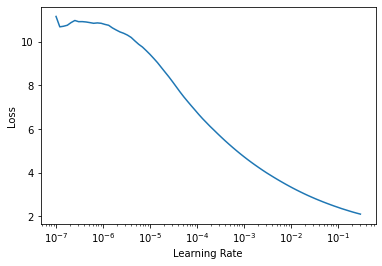

In [34]:
learn.lr_find()

In [35]:
lr = 1e-3
wd = 1e-3

In [39]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
  learn.fit_one_cycle(10, lrs, pct_start=pct_start, wd=wd)
  learn.save(save_name)
  #learn.show_results(ds_idx=1, max_n=5, figsize=(20,20))

In [ ]:
do_fit('1a', slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,time
0,0.009919,0.001222,0.000067,0.001155,08:59
1,0.002271,0.001497,0.000090,0.001407,08:48
2,0.002872,0.001949,0.000167,0.001782,08:47
3,0.003788,0.002600,0.000168,0.002431,08:45
4,0.006311,0.007854,0.000397,0.007457,08:45
5,0.008532,0.006061,0.000360,0.005701,08:45
6,0.016371,0.008106,0.000583,0.007523,08:45
7,0.011409,0.028697,0.001790,0.026907,08:45
8,0.011267,0.016207,0.000991,0.015216,08:46


In [71]:
wd = 1e-3

gc.collect();